In [1]:
import keras
from keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn_keras as iso
from aparent_losses import *
from aparent_visualization import *


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [3]:

seqs = {}

with open('pa_and_smoking/apa_pred.fa', 'r') as f :
    seq_id = ''
    
    for line_raw in f :
        line = line_raw.strip()
        
        if line[0] == '>' :
            seq_id = line[1:]
        else :
            seqs[seq_id] = {'sequence' : line.upper()}


encoder = iso.OneHotEncoder(205)

for seq_id in seqs :
    seqs[seq_id]['one_hot'] = encoder((seqs[seq_id]['sequence'] + 'X' * 100)[:205])


#Load model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
model_path = os.path.join(save_dir, model_name)

model = load_model(model_path)

#Dummy compile
#opt = keras.optimizers.SGD(lr=0.1)
#model.compile(loss='mean_squared_error', optimizer=opt)


#Predict
for seq_id in seqs :
    one_hot = np.reshape(seqs[seq_id]['one_hot'], (1, 205, 4, 1))
    
    _, cut_pred = model.predict(x=[one_hot, np.zeros((1, 13)), np.ones((1, 1))])
    
    seqs[seq_id]['pred_cut'] = np.ravel(cut_pred)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:

def find_cut_region(cuts, max_peak_min_scale=0.3) :
    
    min_peak = max_peak_min_scale * np.max(cuts)
    
    cuts_clipped = cuts - min_peak
    #cuts_clipped = np.amax(cuts, 0)
    
    nonzero_ix = np.nonzero(cuts_clipped > 0.0)[0]
    
    return nonzero_ix[0], nonzero_ix[-1]

for seq_id in seqs :
    
    cut_start, cut_end = find_cut_region(seqs[seq_id]['pred_cut'][:-1], max_peak_min_scale=0.3)
    
    seqs[seq_id]['cut_start'] = cut_start - 1
    seqs[seq_id]['cut_end'] = cut_end + 1
    
    pred_iso = np.sum(seqs[seq_id]['pred_cut'][cut_start: cut_end + 1])
    seqs[seq_id]['pas_score'] = np.log(pred_iso / (1.0 - pred_iso))


In [5]:
#Store dataframe

pred_dict = {
    'seq_id' : [],
    'sequence' : [],
    'cut_start' : [],
    'cut_end' : [],
    'pas_score' : []
}
for seq_id in seqs :
    pred_dict['seq_id'].append(seq_id)
    pred_dict['sequence'].append(seqs[seq_id]['sequence'])
    pred_dict['cut_start'].append(seqs[seq_id]['cut_start'])
    pred_dict['cut_end'].append(seqs[seq_id]['cut_end'])
    pred_dict['pas_score'].append(seqs[seq_id]['pas_score'])

pred_df = pd.DataFrame.from_dict(pred_dict).sort_values(by='pas_score', ascending=False).reset_index(drop=True)
pred_df = pred_df[['seq_id', 'sequence', 'cut_start', 'cut_end', 'pas_score']]

print(pred_df.head())

pred_df.to_csv('pa_smoking_site_predictions.csv', sep='\t', index=False)


              seq_id                                           sequence  \
0  NR_037659_POST(-)  TTTTATAACCCCATTGAGAAGACTAAGTAAGAAATGAAATGTCCTA...   
1  NR_037660_POST(-)  TTTTATAACCCCATTGAGAAGACTAAGTAAGAAATGAAATGTCCTA...   
2  NM_170679_POST(-)  AGGCTCAGATCATCCCTTGACAGTAGTTTGCCTTCATCTCACCTTT...   
3  NM_006930_POST(-)  AGGCTCAGATCATCCCTTGACAGTAGTTTGCCTTCATCTCACCTTT...   
4  NM_144665_POST(-)  TTGCAGAAATTTATTTCATTGTTATTAGTAGGAATTTTATTGGTTC...   

   cut_start  cut_end  pas_score  
0         92       99   1.895437  
1         92       99   1.895437  
2         92       99   1.634833  
3         92       99   1.634833  
4         63       72   1.591352  




----------------------------------------------
PAS visualization for NM_016442_PRE(-)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


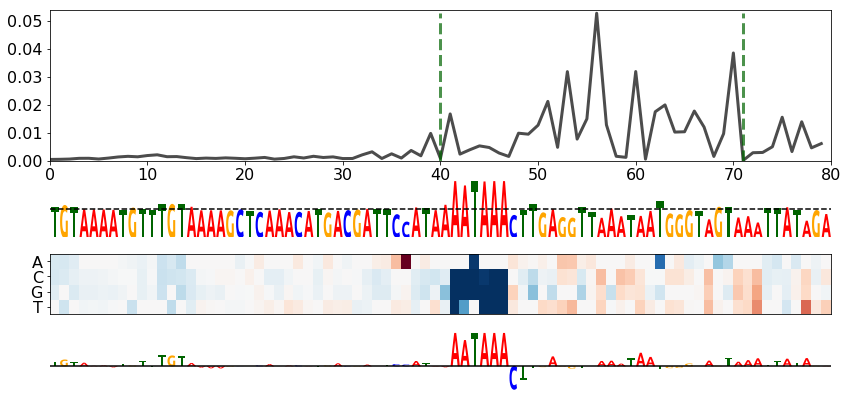



----------------------------------------------
PAS visualization for NM_016442_POST(-)


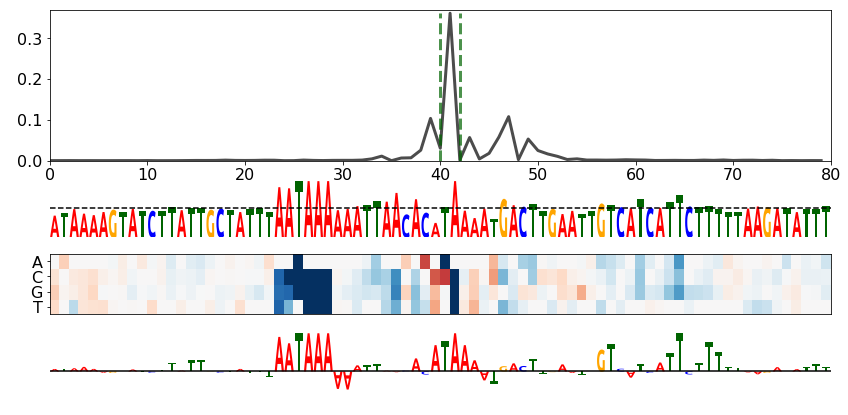



----------------------------------------------
PAS visualization for NM_001144967_POST(+)


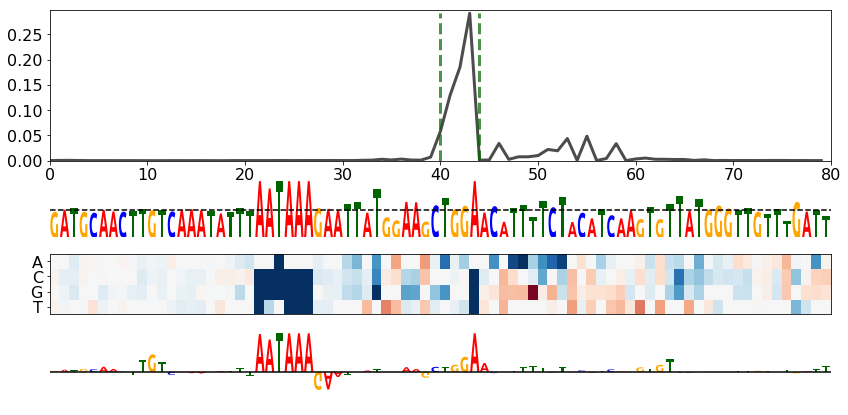

NM_001243960_POST(+) same sequence as above.
NM_015277_POST(+) same sequence as above.
NM_001144964_POST(+) same sequence as above.
NM_001144965_POST(+) same sequence as above.
NM_001144968_POST(+) same sequence as above.
NM_001144969_POST(+) same sequence as above.
NM_001144971_POST(+) same sequence as above.
NM_001144970_POST(+) same sequence as above.
NM_001144966_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_144665_PRE(-)


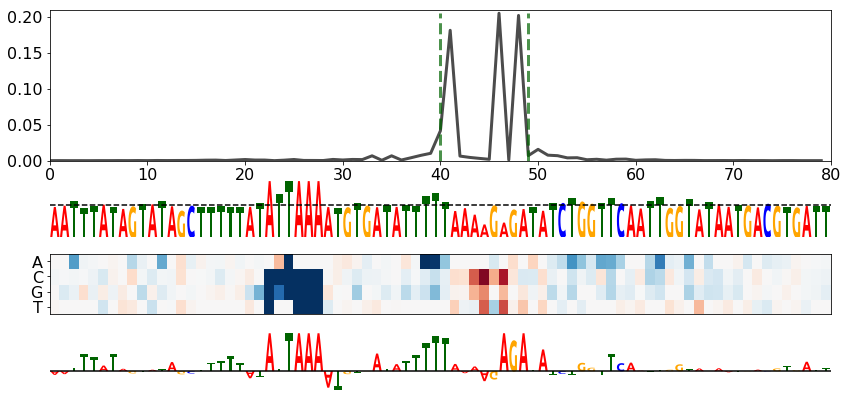



----------------------------------------------
PAS visualization for NM_144665_POST(-)


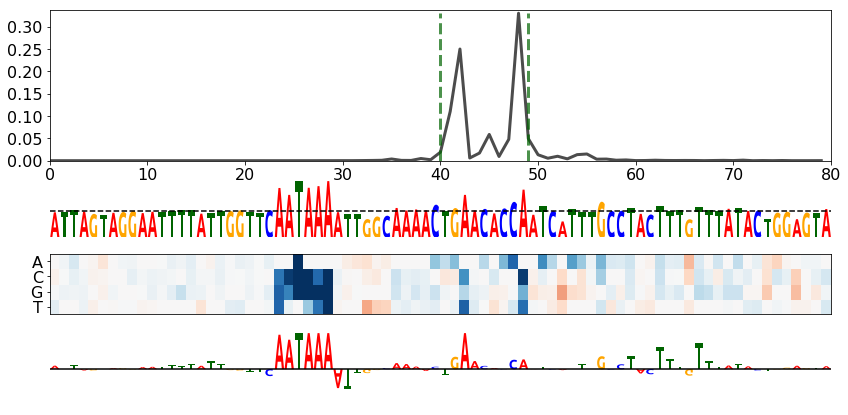

NM_001271594_PRE(-) same sequence as above.
NM_001271594_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_015134_POST(+)


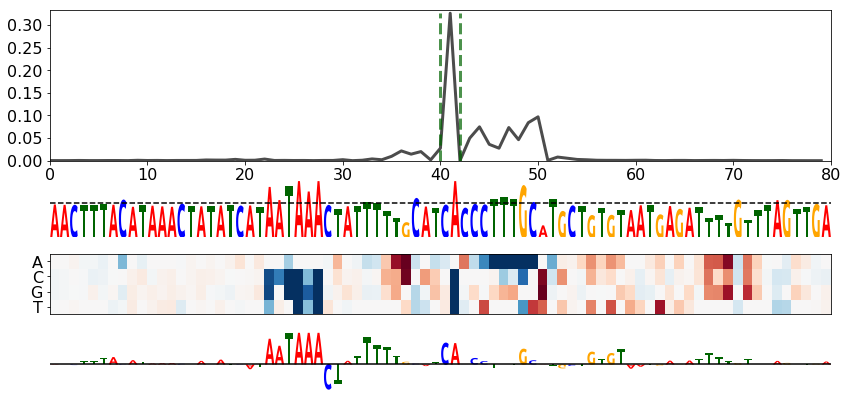

NM_201274_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_177952_POST(+)


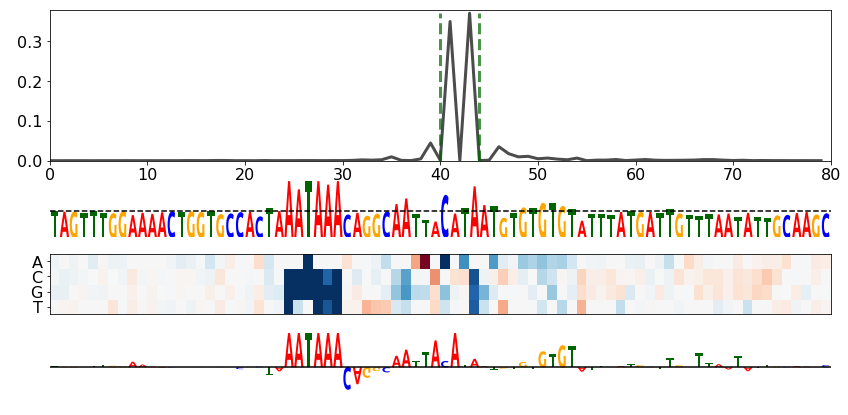

NM_021003_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_001010942_POST(+)


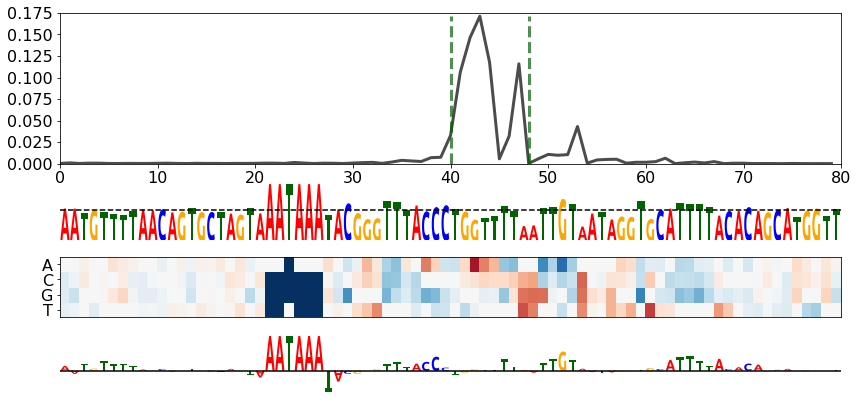

NM_001251917_POST(+) same sequence as above.
NM_001251918_POST(+) same sequence as above.
NM_001251921_POST(+) same sequence as above.
NM_001251922_POST(+) same sequence as above.
NM_015646_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_000636_POST(-)


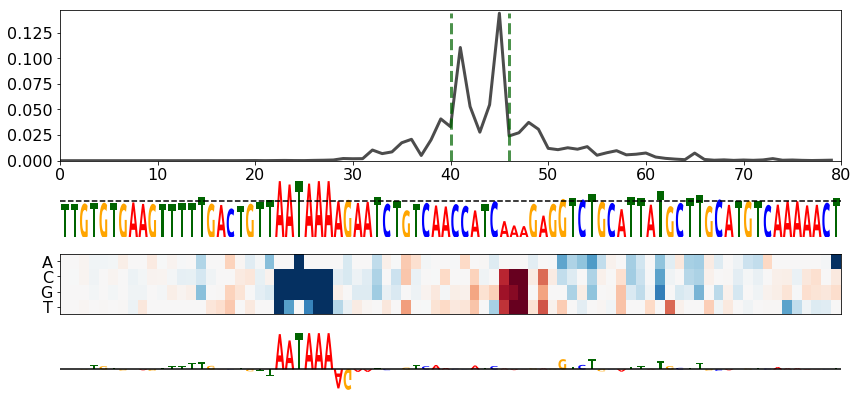

NM_001322814_POST(-) same sequence as above.
NM_001322815_POST(-) same sequence as above.
NM_001322820_POST(-) same sequence as above.
NM_001322819_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_001973_PRE(-)


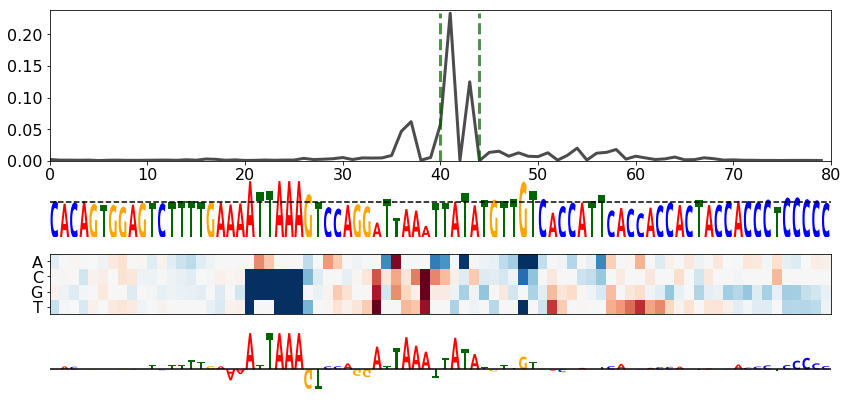



----------------------------------------------
PAS visualization for NM_001973_POST(-)


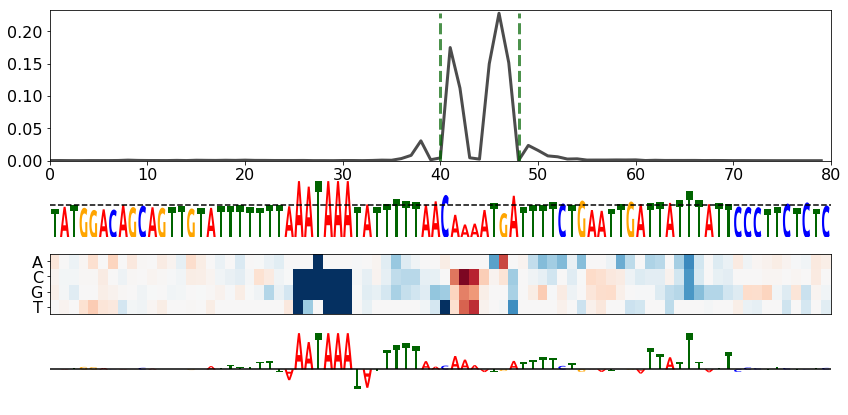



----------------------------------------------
PAS visualization for NM_001286810_POST(+)


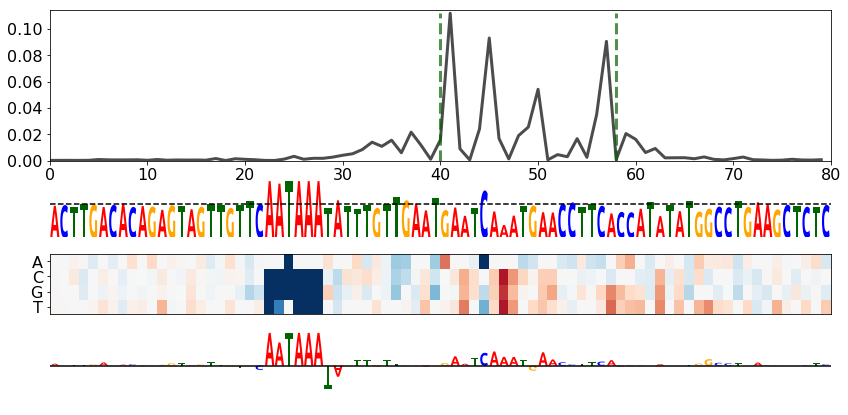

NM_024345_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_006578_POST(-)


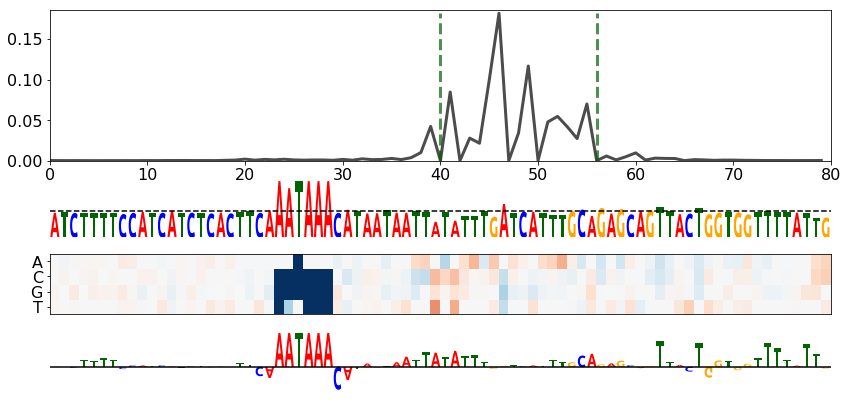

NM_016194_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_054027_PRE(-)


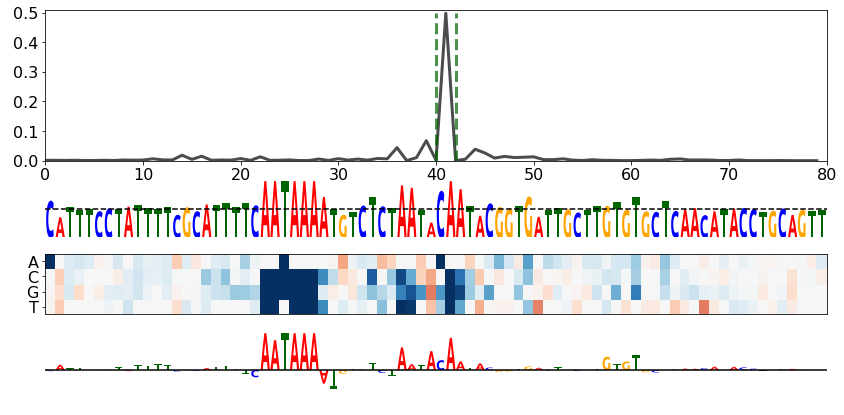



----------------------------------------------
PAS visualization for NM_054027_POST(-)


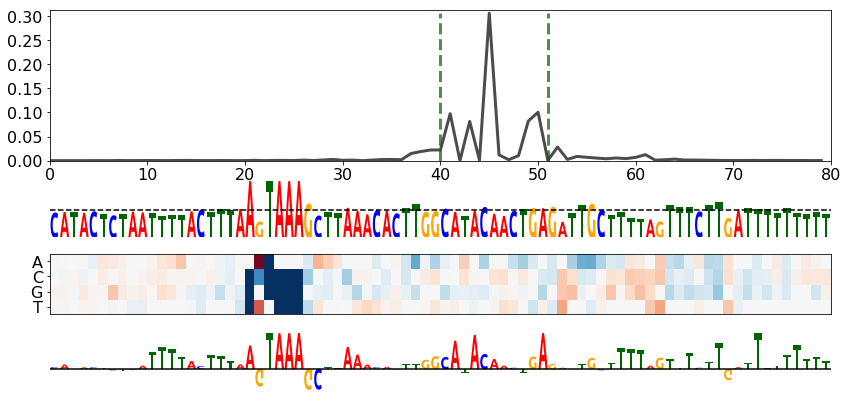



----------------------------------------------
PAS visualization for NM_001130006_POST(-)


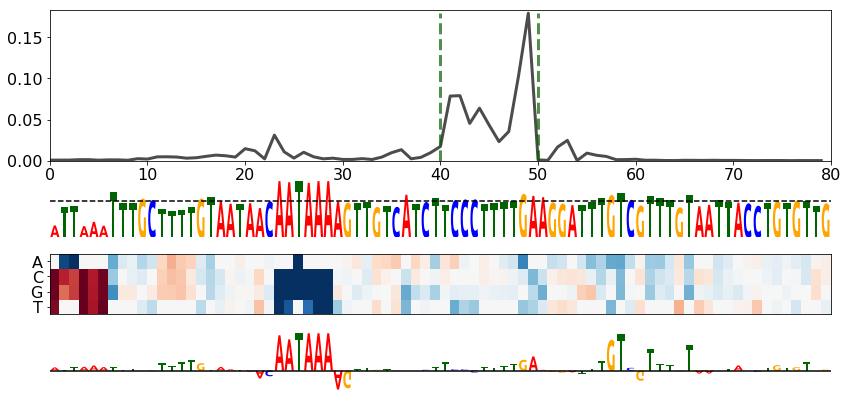

NM_002094_POST(-) same sequence as above.
NM_001130007_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_001122681_POST(+)


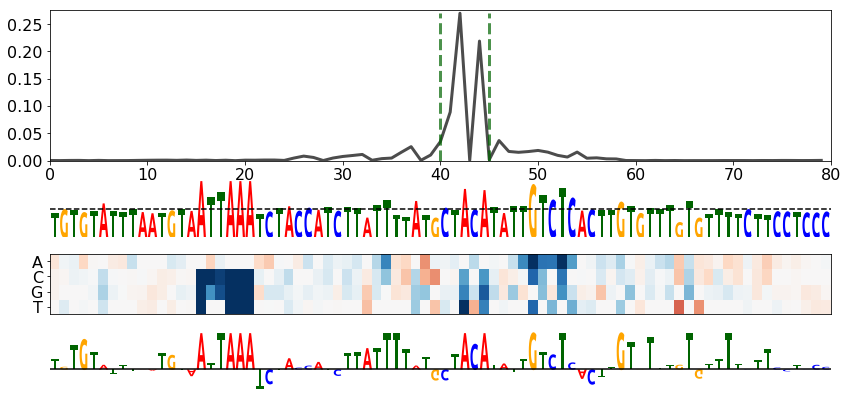

NM_001145855_POST(+) same sequence as above.
NM_001145856_POST(+) same sequence as above.
NM_003023_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_003569_PRE(-)


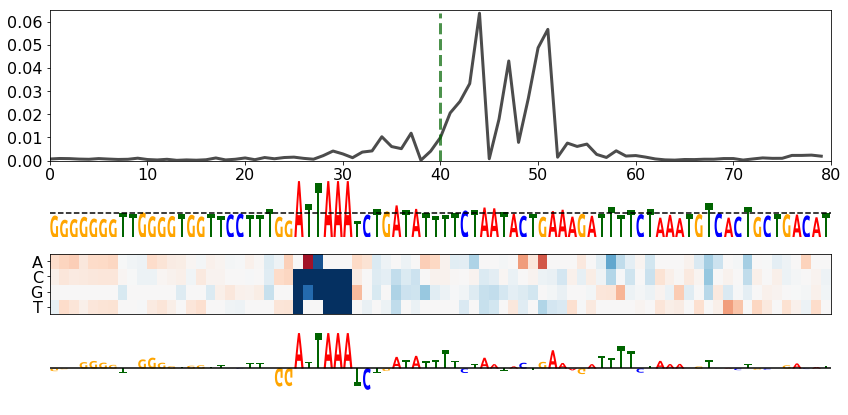



----------------------------------------------
PAS visualization for NM_003569_POST(-)


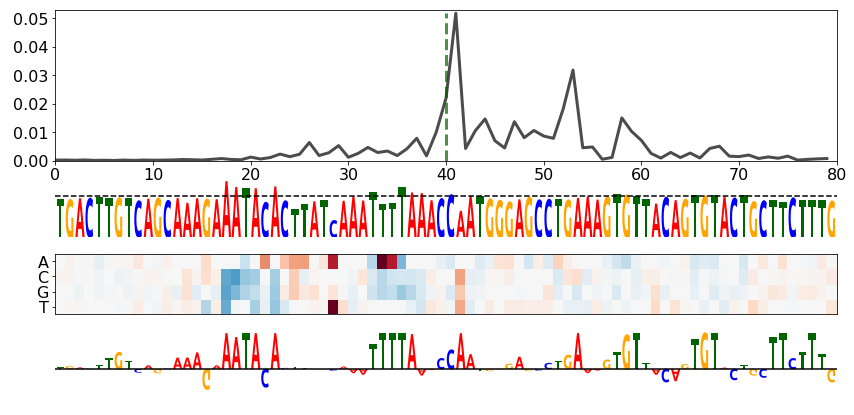

NM_001326578_PRE(-) same sequence as above.
NM_001326578_POST(-) same sequence as above.
NR_137169_POST(-) same sequence as above.
NM_001326579_PRE(-) same sequence as above.
NM_001326579_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NR_037660_POST(-)


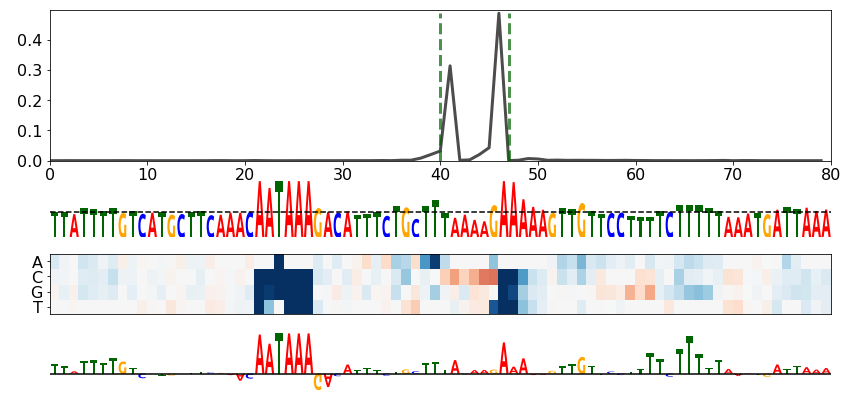

NR_037659_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_177951_PRE(+)


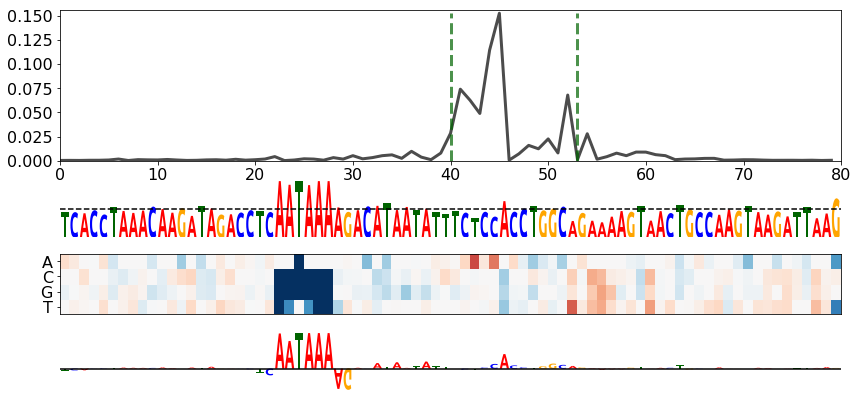



----------------------------------------------
PAS visualization for NM_177951_POST(+)


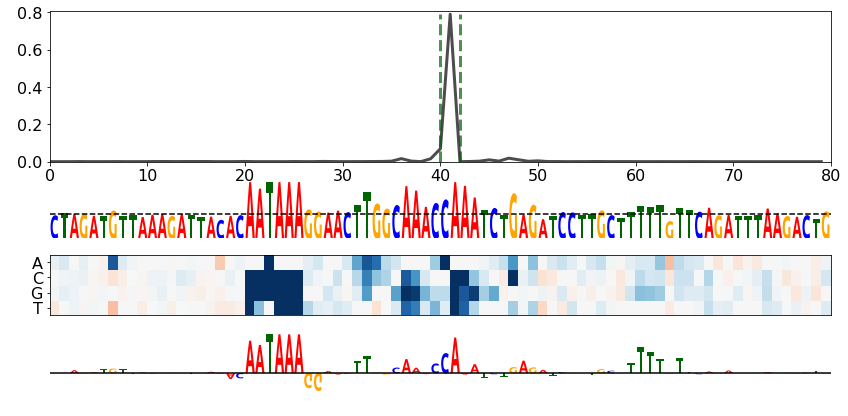



----------------------------------------------
PAS visualization for NM_001024843_POST(+)


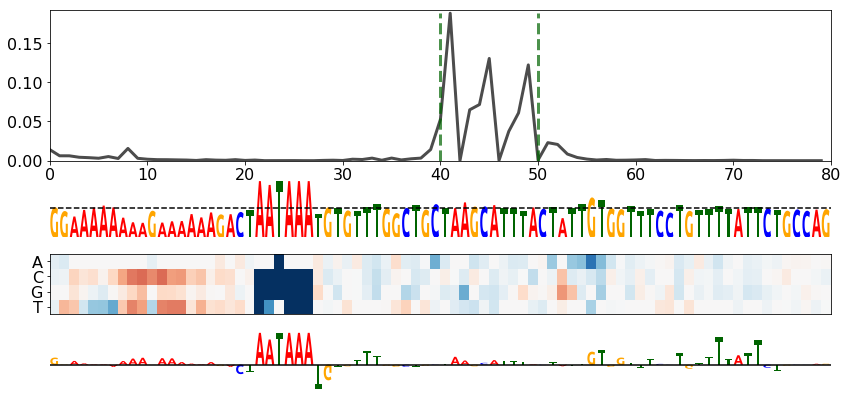

NM_001162501_POST(+) same sequence as above.
NM_015088_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_030647_PRE(-)


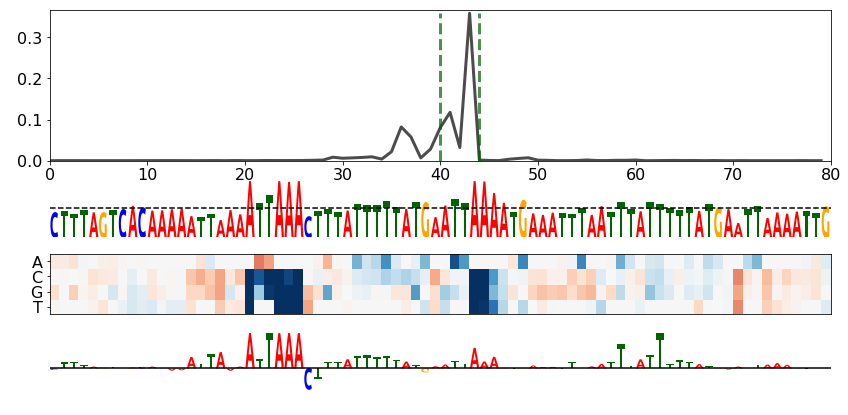



----------------------------------------------
PAS visualization for NM_030647_POST(-)


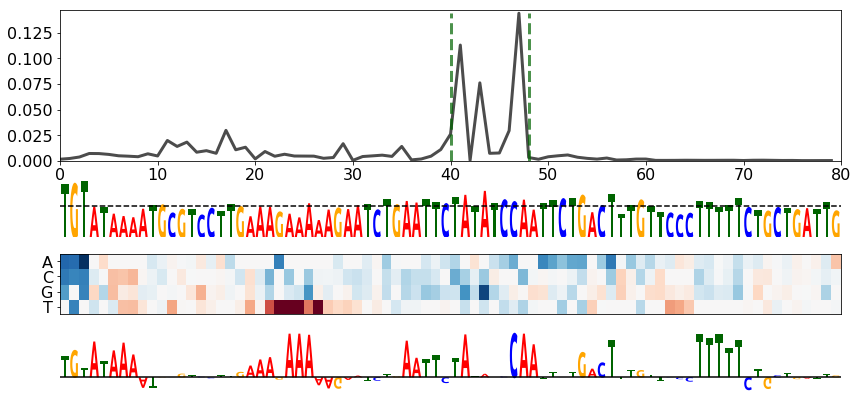



----------------------------------------------
PAS visualization for NM_006930_POST(-)


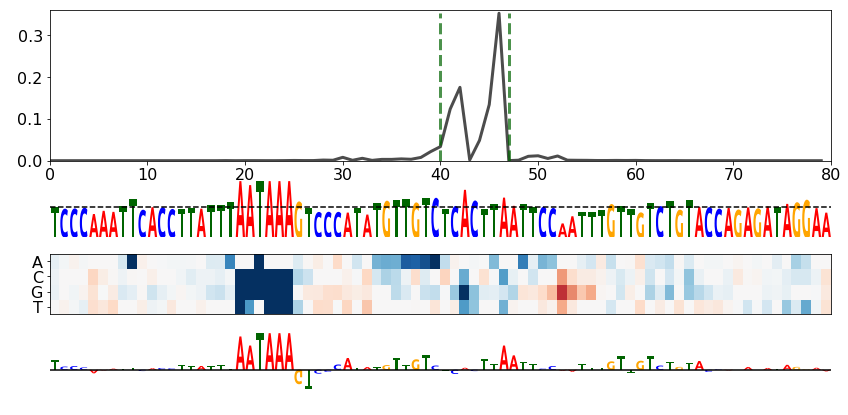

NM_170679_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_001243765_PRE(+)


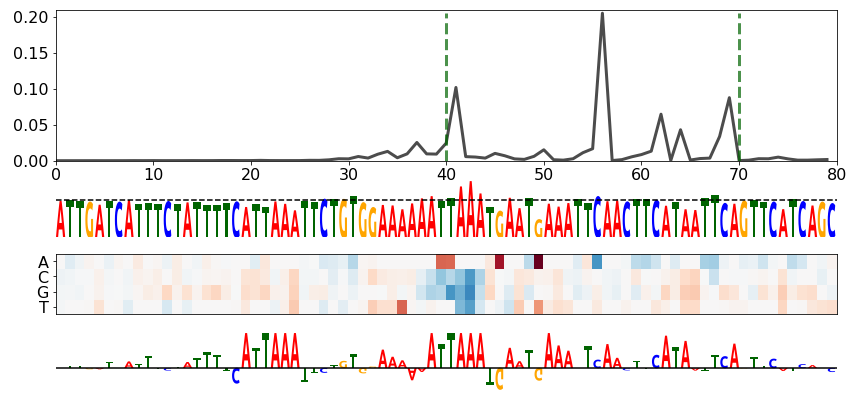

NM_001243764_PRE(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_002270_POST(+)


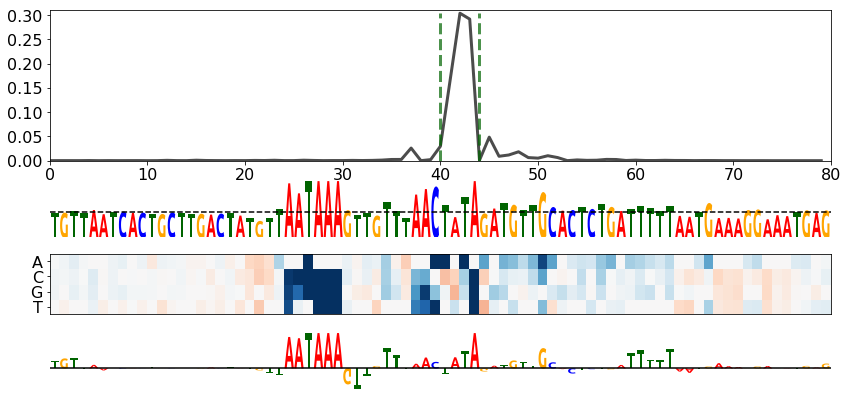

NM_153188_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NR_046359_POST(-)


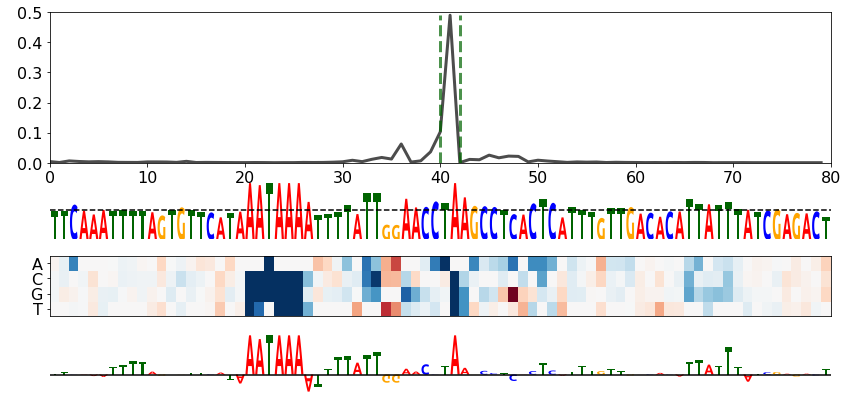

NR_046360_POST(-) same sequence as above.
NR_046361_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_001160124_PRE(-)


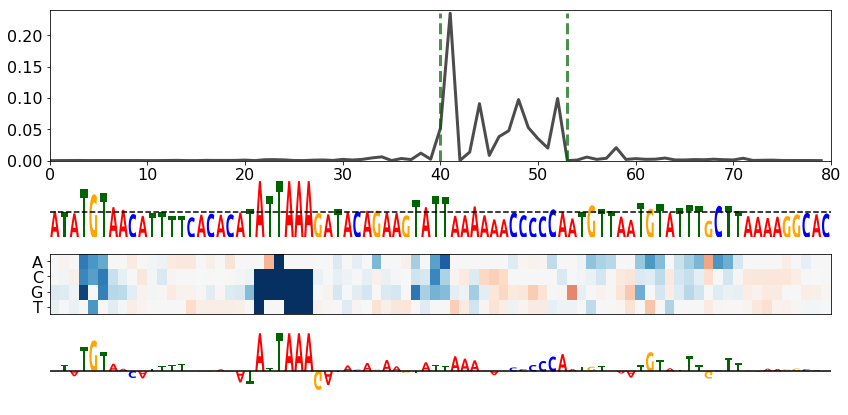



----------------------------------------------
PAS visualization for NM_001160124_POST(-)


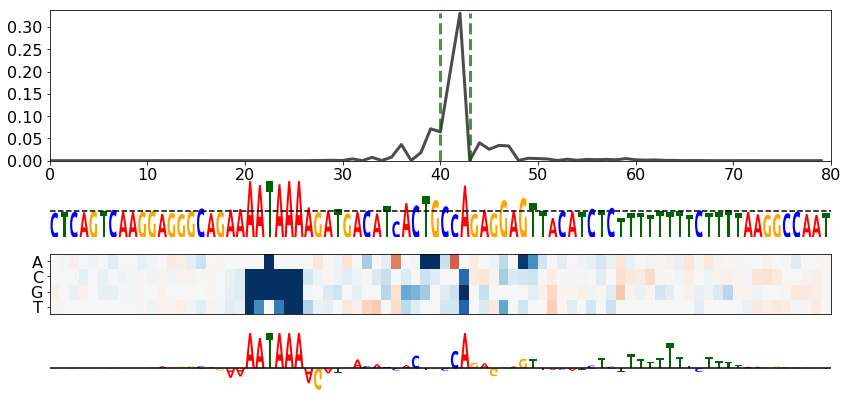

NM_001160125_PRE(-) same sequence as above.
NM_001160125_POST(-) same sequence as above.
NM_001300_PRE(-) same sequence as above.
NM_001300_POST(-) same sequence as above.
NR_027653_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_001308116_POST(-)


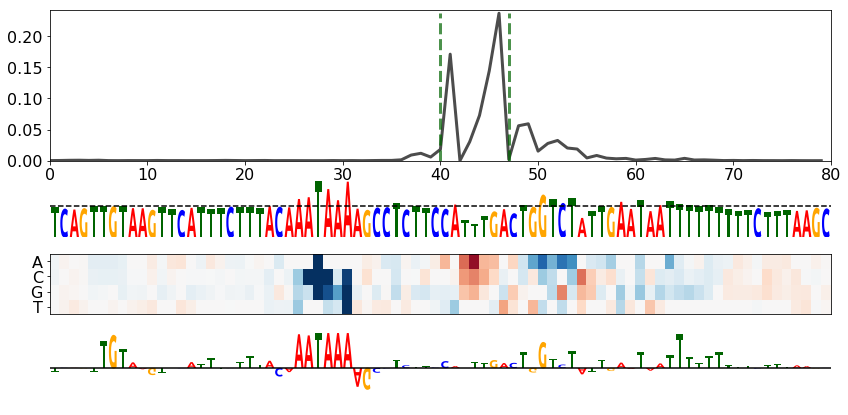

NM_024947_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_016353_POST(+)


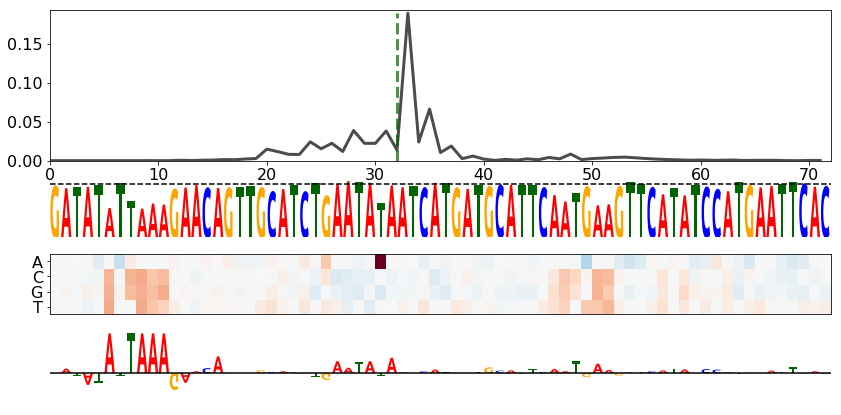



----------------------------------------------
PAS visualization for NM_001136264_POST(+)


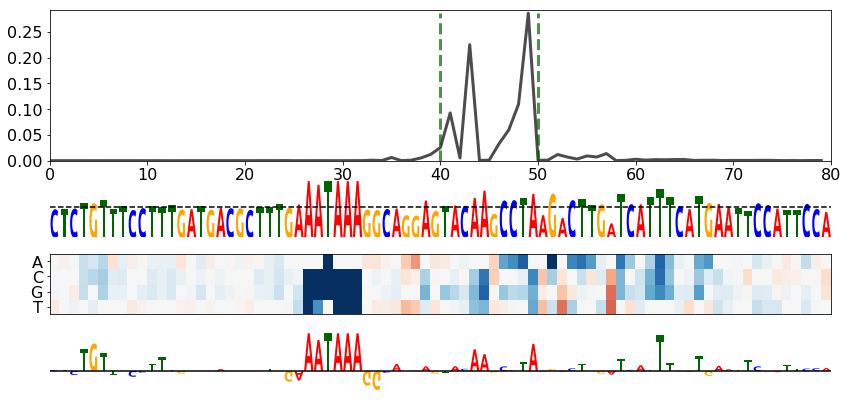

NM_001136266_POST(+) same sequence as above.
NM_001136267_POST(+) same sequence as above.
NM_001136268_POST(+) same sequence as above.
NM_014764_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_000314_PRE(+)


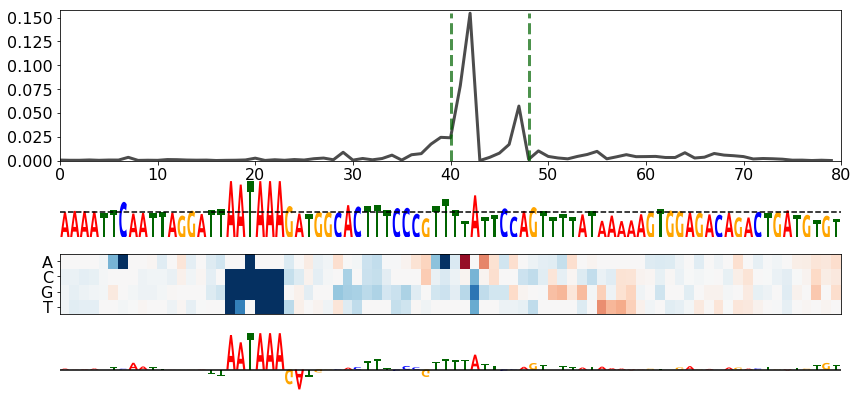



----------------------------------------------
PAS visualization for NM_000314_POST(+)


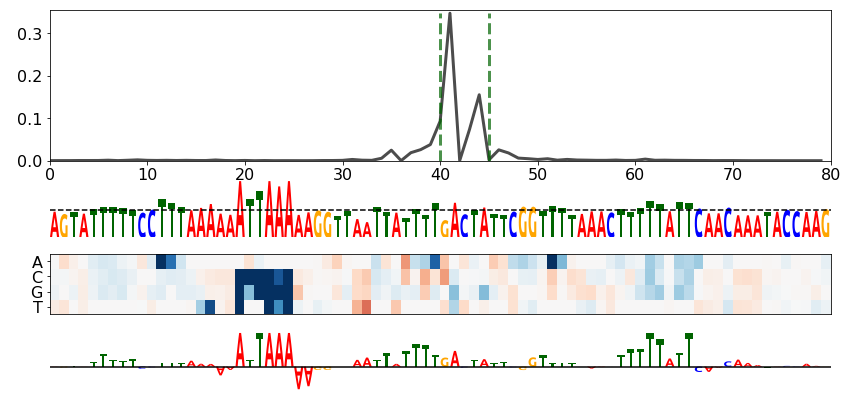

NM_001304717_PRE(+) same sequence as above.
NM_001304717_POST(+) same sequence as above.
NM_001304718_PRE(+) same sequence as above.
NM_001304718_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_003387_PRE(-)


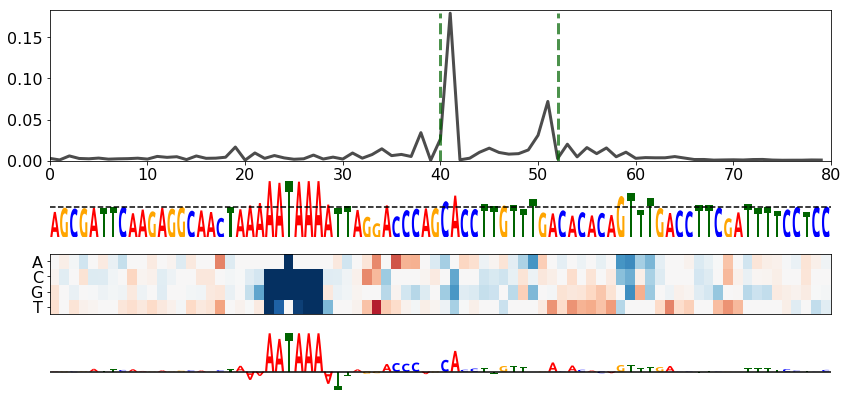



----------------------------------------------
PAS visualization for NM_003387_POST(-)


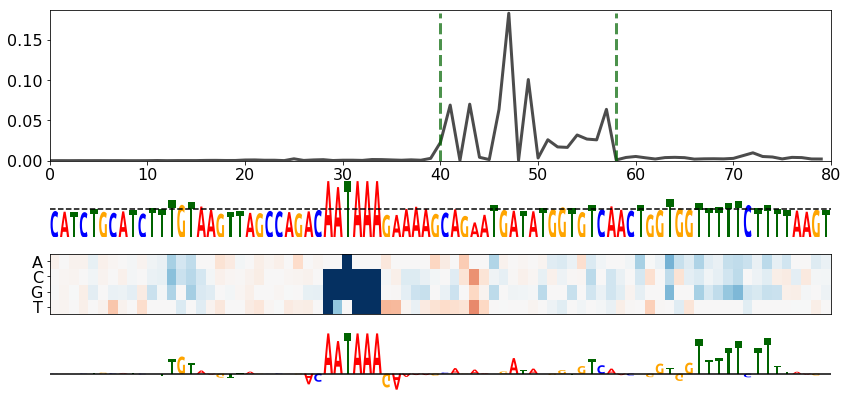

NM_001077269_PRE(-) same sequence as above.
NM_001077269_POST(-) same sequence as above.


----------------------------------------------
PAS visualization for NM_001243765_POST(+)


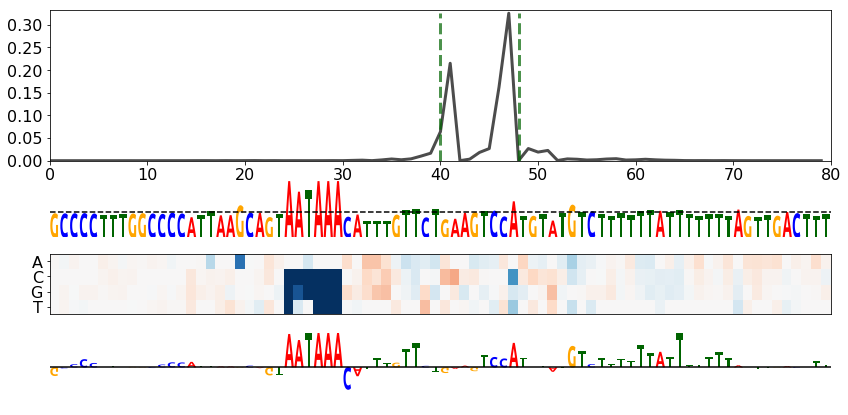

NM_001243764_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_001202516_POST(+)


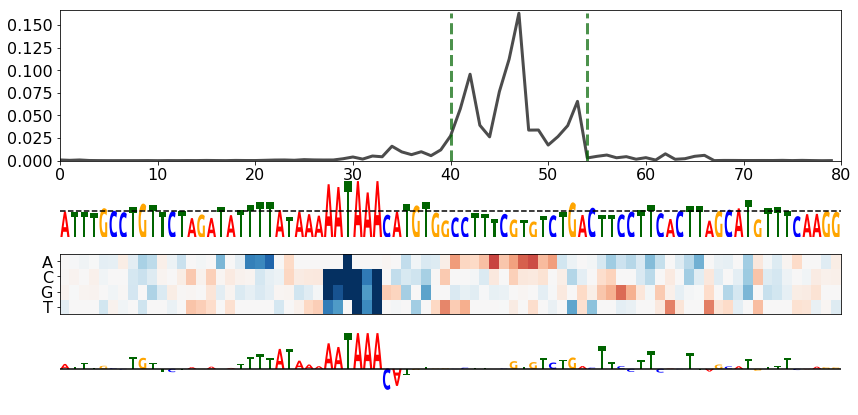

NM_001202517_POST(+) same sequence as above.
NM_001202519_POST(+) same sequence as above.
NM_003879_POST(+) same sequence as above.
NM_001127183_POST(+) same sequence as above.
NM_001202518_POST(+) same sequence as above.
NM_001202515_POST(+) same sequence as above.


----------------------------------------------
PAS visualization for NM_007124_PRE(+)


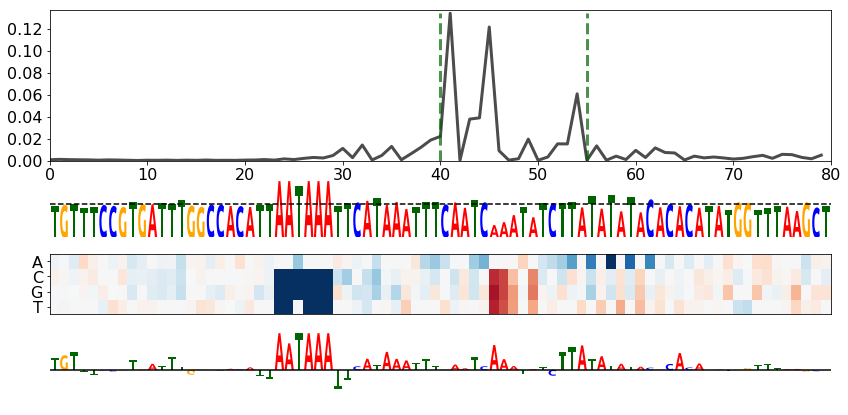



----------------------------------------------
PAS visualization for NM_007124_POST(+)


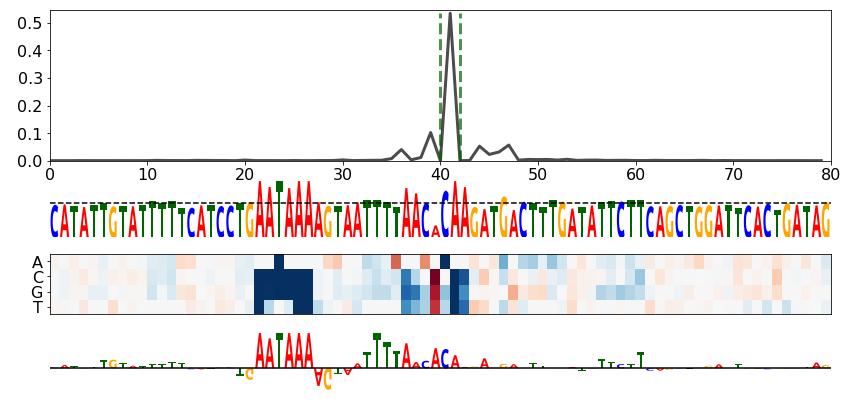



----------------------------------------------
PAS visualization for NM_001171905_PRE(+)


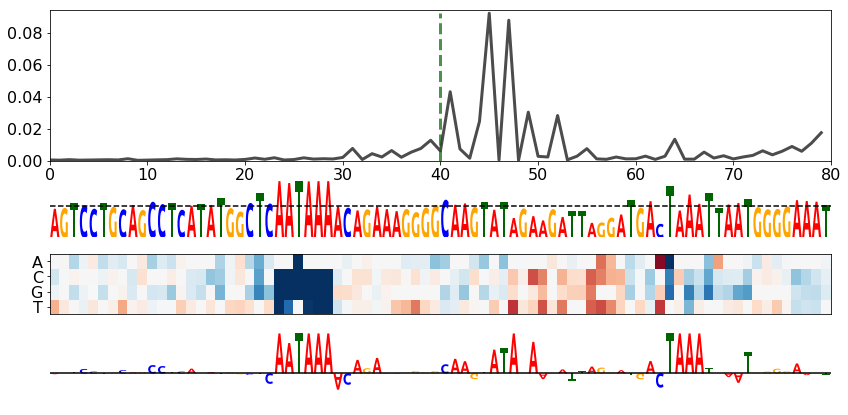



----------------------------------------------
PAS visualization for NM_001171905_POST(+)


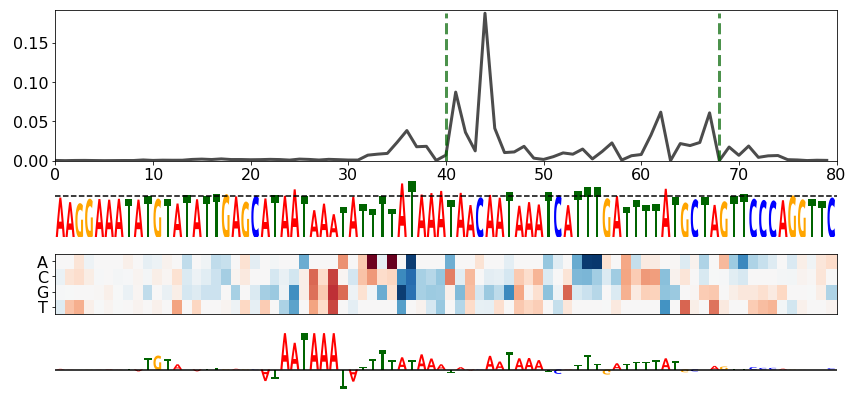

NM_152395_PRE(+) same sequence as above.
NM_152395_POST(+) same sequence as above.


In [7]:
seq_visited = {}

for seq_id in seqs :
    
    if seqs[seq_id]['sequence'] in seq_visited :
        print(seq_id + ' same sequence as above.')
        
        continue
    
    print('')
    print('')
    print('----------------------------------------------')
    print("PAS visualization for " + seq_id)
    
    seq_visited[seqs[seq_id]['sequence']] = True
    
    seq_start = max(seqs[seq_id]['cut_start'] - 40, 0)#50
    seq_end = min(seqs[seq_id]['cut_start'] + 40, 200)#150

    isoform_start = 40 + min(seqs[seq_id]['cut_start'] - 40, 0)
    isoform_end = 40 + min(seqs[seq_id]['cut_start'] - 40, 0) + seqs[seq_id]['cut_end'] - seqs[seq_id]['cut_start']

    guided_backprop = GuidedBackprop(model, isoform_start=seq_start+isoform_start, isoform_end=seq_start+isoform_end, guidedReluRegistered=True)
    integrated_guided_backprop = IntegratedGradients(model, guided_backprop, nt_baseline=0.0)

    mut_map(
        model,
        seqs[seq_id]['sequence'],
        [],
        seq_start=seq_start,
        seq_end=seq_end,
        isoform_start=isoform_start,
        isoform_end=isoform_end,
        figsize=(14, 7),
        height_ratios=[5, 2, 2, 2],
        bg_alpha=0.5,
        border_eta = 0.085,
        logodds_clip=1.0,
        seq_mask_model=integrated_guided_backprop,
        smoothed_grad=False,
        max_grad_clip=0.5
    )
